In [ ]:
# !pip update numpy

# # !pip install --force-reinstall --no-deps numpy==1.23.5
# !rm -r /anaconda/envs/azureml_py38/lib/python3.10/site-packages/numpy-1.23.5.dist-info/

In [ ]:
!conda create -n cleanenv python=3.10
!conda activate cleanenv
!pip install fiftyone umap-learn numba numpy

In [ ]:
!pip install numpy==1.23.5 ultralytics transformers opencv-python torch torchvision huggingface open_clip_torch 

In [2]:
import torch
import cv2
import os
import glob
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import subprocess
from ultralytics import YOLO, SAM
import matplotlib.pyplot as plt
import open_clip
from transformers import CLIPProcessor, CLIPModel
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.core.labels as fol

/anaconda/envs/cleanenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
file_path = "./Benthic-Mapping-highlight/benthic_mapping/model.pt"
yolo_model = YOLO(file_path) # Instantiate your model

In [4]:
#Load yolo model for obj detection

yolo_model = YOLO("yolov8n.pt")

bio_model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
bio_model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
bio_model = bio_model.to(device)

#Clip model for embeddings
# clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")
clip_model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

In [5]:
def get_clip_embeddings(image):
    inputs = clip_processor(images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = clip_model.get_image_features(**inputs)
    return outputs / outputs.norm(p=2, dim = 1, keepdim=True)
def get_bioclip_embeddings(image):
    # Preprocess image using BioCLIP's validation transform
    image_input = preprocess_val(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        image_features = bio_model.encode_image(image_input)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)  # Normalize
    
    return image_features

def extract_objects_with_embeddings(yolo_model,frame):
    results = yolo_model(frame)
    objects = []
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].int().tolist()
        cropped = frame[y1:y2, x1:x2]
        if cropped.shape[0] > 0 and cropped.shape[1] > 0:
            # Convert the cropped image to PIL format
            pil_image = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
            emb = get_clip_embeddings(pil_image)
            objects.append((emb, (x1, y1, x2, y2)))
        return objects
        # x1, y1, x2, y2 = map(int, box.xyxy[0])
        # obj = frame[y1:y2, x1:x2]
        # objects.append(obj)
    #return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [6]:
def detect_objects(image):
    """
    Detect objects in an image using YOLOv8 from ultralytics.
    
    Args:
        image (numpy.ndarray): Input image in BGR format.
        embedding: CLIP embedding (not used in this example, but available to integrate if needed).
        
    Returns:
        list: A list of dictionaries with keys 'label' and 'bbox'. The bbox is a tuple (x_min, y_min, x_max, y_max).
    """
    # Load a pre-trained YOLOv8 model (ensure you have ultralytics installed)
    model = YOLO("yolov8n.pt")  # or use another weight file/model as needed
    # model = SAM("sam2.1_b.pt")
    file_path = "./Benthic-Mapping-highlight/benthic_mapping/model.pt"
    model = YOLO(file_path) # Instantiate your model
    # Run the model on the image; the model accepts BGR images if using cv2 images
    results = model(image)
    detections = []
    # Iterate over each result (usually one result per image)
    for result in results:
        # result.boxes contains detections in xyxy format and other information
        for box in result.boxes:
            # Extract bounding box coordinates and convert to integers
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            # Append detection as a dictionary
            detections.append({
                "bbox": (int(x1), int(y1), int(x2), int(y2))
            })
    print(detections)
    return detections

In [7]:
def get_clip_embeddings_for_detected_objects(cv2image, yolo_model, clip_model):
    """
    Detects objects in an image and returns CLIP embeddings for each detected object.

    Args:
        cv2image (np.ndarray): The input image in BGR format (from OpenCV).
        yolo_model: Initialized Ultralytics YOLO model.
        clip_model: Initialized CLIP image encoder.
        clip_preprocess_function: Preprocessing function for the CLIP model.
        device (str): Device to run CLIP model on ('cuda' or 'cpu').

    Returns:
        list: A list of dictionaries, where each dictionary contains:
              'bbox': (x1, y1, x2, y2) coordinates of the detected object.
              'class_id': class ID from YOLO.
              'confidence': confidence score from YOLO.
              'clip_embedding': torch.Tensor containing the CLIP embedding for the object.
              Returns an empty list if no objects are detected or an error occurs.
    """

    # 1. Detect Objects using YOLO
    yolo_results = yolo_model(cv2image, verbose=False) # verbose=False to reduce console output

    object_embeddings_data = []

    if yolo_results and len(yolo_results) > 0:
        # Assuming results for a single image, so take the first element
        detections = yolo_results[0]
        boxes = detections.boxes # Access the Boxes object

        for i in range(len(boxes)):
            box = boxes[i]
            xyxy = box.xyxy[0].cpu().numpy().astype(int) # Get (x1, y1, x2, y2)
            # class_id = int(box.cls[0].cpu().numpy()) if box.cls is not None else -1
            # confidence = float(box.conf[0].cpu().numpy()) if box.conf is not None else 0.0

            x1, y1, x2, y2 = xyxy

            # 2. Crop the detected object from the original image
            # Ensure coordinates are within image bounds and valid
            if x1 >= x2 or y1 >= y2:
                # print(f"Warning: Invalid bounding box coordinates for object {i}: {xyxy}. Skipping.")
                continue
            
            # Clamp coordinates to be within image dimensions to avoid errors during cropping
            img_h, img_w = cv2image.shape[:2]
            x1_c = max(0, x1)
            y1_c = max(0, y1)
            x2_c = min(img_w, x2)
            y2_c = min(img_h, y2)

            if x1_c >= x2_c or y1_c >= y2_c: # If clamped box is invalid
                # print(f"Warning: Clamped bounding box is invalid for object {i}: ({x1_c},{y1_c},{x2_c},{y2_c}). Skipping.")
                continue

            cropped_object_bgr = cv2image[y1_c:y2_c, x1_c:x2_c]

            if cropped_object_bgr.size == 0:
                # print(f"Warning: Cropped object {i} is empty. BBox: {xyxy}. Clamped BBox: ({x1_c},{y1_c},{x2_c},{y2_c}). Skipping.")
                continue

            # 3. Preprocess the cropped object for CLIP
            #    a. Convert BGR (OpenCV) to RGB
            cropped_object_rgb = cv2.cvtColor(cropped_object_bgr, cv2.COLOR_BGR2RGB)
            #    b. Convert NumPy array to PIL Image
            pil_image = Image.fromarray(cropped_object_rgb)
            #    c. Apply CLIP preprocessing
            inputs = clip_processor(images=pil_image, return_tensors="pt", padding=True)
            
            # 4. Get CLIP embedding for the cropped object
            with torch.no_grad():
                outputs = clip_model.get_image_features(**inputs)
            object_embedding =  outputs / outputs.norm(p=2, dim = 1, keepdim=True)

            object_embeddings_data.append({
                'bbox': (x1, y1, x2, y2),
                # 'class_id': class_id,
                # 'confidence': confidence,
                'clip_embedding': object_embedding.cpu() # Move to CPU if you plan to store/use it there
            })

    return object_embeddings_data



0: 640x640 6 items, 71.7ms
Speed: 3.3ms preprocess, 71.7ms inference, 95.8ms postprocess per image at shape (1, 3, 640, 640)
[{'bbox': (481, 888, 563, 958)}, {'bbox': (102, 934, 139, 978)}, {'bbox': (145, 516, 574, 881)}, {'bbox': (2, 389, 199, 596)}, {'bbox': (102, 221, 1024, 829)}, {'bbox': (563, 568, 761, 795)}]
{'bbox': (481, 888, 563, 958)}
{'bbox': (102, 934, 139, 978)}
{'bbox': (145, 516, 574, 881)}
{'bbox': (2, 389, 199, 596)}
{'bbox': (102, 221, 1024, 829)}
{'bbox': (563, 568, 761, 795)}


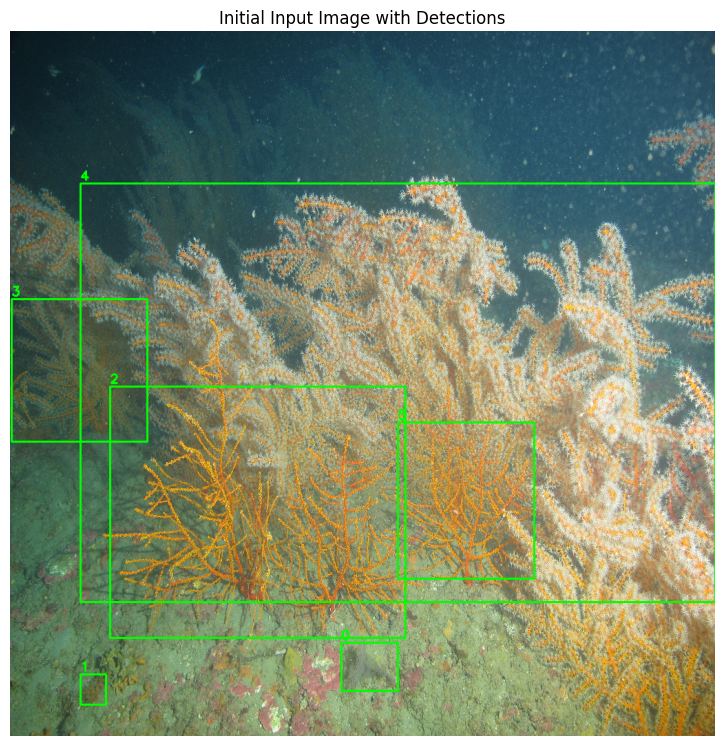

In [8]:
file_path = "./Benthic-Mapping-highlight/benthic_mapping/model.pt"
yolo_model = YOLO(file_path) # Instantiate your model
im_path = './Benthic-Mapping-highlight/benthic_mapping/data/Images/PS2222_20220601T162145Z_FWD_ROV01_IMG_0151.JPG'
# similar_objects = []
SIMILARITY_THRESHOLD = 0.7
frame_idx = 0

query_image = Image.open(im_path)
query_image = cv2.imread(im_path)
query_image = cv2.resize(query_image, (1024, 1024), interpolation=cv2.INTER_CUBIC)
query_embedding = get_clip_embeddings(query_image)

# Convert the frame to RGB for displaying with matplotlib
detections = detect_objects(query_image)
output_image = query_image.copy()
for i,detection in enumerate(detections):
    # if i == 0:
        print(detection)
        x_min, y_min, x_max, y_max = detection["bbox"]
        # Draw rectangle and label
        cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
        label = str(i)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        thickness = 2
        text_color = (0, 255, 0)  # Green, matches the box

        # Calculate text size (optional, helps align better)
        (text_width, text_height), _ = cv2.getTextSize(label, font, font_scale, thickness)

        # Offset so the text is just above the box
        text_x = x_min
        text_y = y_min - 5 if y_min - 5 > text_height else y_min + text_height + 5

        # Put text on image
        cv2.putText(output_image, label, (text_x, text_y), font, font_scale, text_color, thickness)
frame_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display the frame with the bounding box
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(frame_rgb)
plt.axis('off')
plt.title(f"Initial Input Image with Detections")
plt.show()
object_embeddings = get_clip_embeddings_for_detected_objects(query_image, yolo_model, clip_model)


In [9]:
columns = ['media_id', 'frame_num', 'bbox', 'embedding_vec']
media_id =  '4291234'

# Create an empty DataFrame
embedding_df = pd.DataFrame(columns=columns)

file_path = "./Benthic-Mapping-highlight/benthic_mapping/model.pt"
yolo_model = YOLO(file_path) # Instantiate your model


similar_objects = []
SIMILARITY_THRESHOLD = 0.6
query_embedding = object_embeddings[4]['clip_embedding']
folder_path = './Benthic-Mapping-highlight/benthic_mapping/data/Images/'

# Get all .jpg files in the folder
jpg_files = glob.glob(os.path.join(folder_path, '*.JPG'))
print(jpg_files)
for l,image_path in enumerate(jpg_files):
        print(l)      
    # if l < 20:
        print(f"Processing: {image_path}")
    

    # cap = cv2.VideoCapture(video_path)
        query_image = cv2.imread(image_path)
        media_id = os.path.basename(image_path)
        print(media_id)
        objects = get_clip_embeddings_for_detected_objects(query_image, yolo_model, clip_model)
        if objects is None:
            print("No objects detected.")
            continue
        for detection in objects:
            emb, bbox = detection['clip_embedding'], detection['bbox']
            new_row = {
                    'media_id': media_id,
                    'frame_num': 'image',
                    'bbox': bbox,
                    'embedding_vec': emb
            }
            embedding_df.loc[len(embedding_df)] = new_row
            # Calculate cosine similarity
            similarity = cosine_similarity(query_embedding.numpy(), emb.numpy())[0][0]

            if similarity > SIMILARITY_THRESHOLD:
                similar_objects.append((media_id, bbox, similarity))
                print(f'Object added with similarity: {similarity}')
                #Optional to draw box
                x1, y1, x2, y2 = bbox
                cv2.rectangle(query_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(query_image, f"Similarity: {similarity:.2f}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

['./Benthic-Mapping-highlight/benthic_mapping/data/Images/PS2222_20220601T153543Z_FWD_ROV01_IMG_0001.JPG', './Benthic-Mapping-highlight/benthic_mapping/data/Images/PS2222_20220601T153604Z_FWD_ROV01_IMG_0002.JPG', './Benthic-Mapping-highlight/benthic_mapping/data/Images/PS2222_20220601T153620Z_FWD_ROV01_IMG_0003.JPG', './Benthic-Mapping-highlight/benthic_mapping/data/Images/PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG', './Benthic-Mapping-highlight/benthic_mapping/data/Images/PS2222_20220601T153819Z_FWD_ROV01_IMG_0005.JPG', './Benthic-Mapping-highlight/benthic_mapping/data/Images/PS2222_20220601T153839Z_FWD_ROV01_IMG_0006.JPG', './Benthic-Mapping-highlight/benthic_mapping/data/Images/PS2222_20220601T153924Z_FWD_ROV01_IMG_0007.JPG', './Benthic-Mapping-highlight/benthic_mapping/data/Images/PS2222_20220601T154100Z_FWD_ROV01_IMG_0008.JPG', './Benthic-Mapping-highlight/benthic_mapping/data/Images/PS2222_20220601T154117Z_FWD_ROV01_IMG_0009.JPG', './Benthic-Mapping-highlight/benthic_mapping/

In [10]:
display(embedding_df)
image_dir = './Benthic-Mapping-highlight/benthic_mapping/data/Images/'
if "df-object-embeddings" in fo.list_datasets():
    fo.delete_dataset("df-object-embeddings")

dataset = fo.Dataset("df-object-embeddings")
# dataset = fo.utils.dataset.import_dataset(
#     dataset_type=fo.types.ImageDirectory,
#     dataset_dir=image_dir,
#     name='MDBC_images'
# )


df = embedding_df.copy()
for idx, row in df.iterrows():
    image_path = os.path.join(image_dir, row["media_id"])
    if not os.path.exists(image_path):
        continue

    # Get original image to compute bbox thumbnail
    image = cv2.imread(image_path)
    if image is None:
        continue

    h, w = image.shape[:2]
    x1, y1, x2, y2 = row["bbox"]

    # Convert to relative [x, y, w, h]
    x = x1 / w
    y = y1 / h
    box_w = (x2 - x1) / w
    box_h = (y2 - y1) / h

    # Create a new sample for this single detection
    sample = fo.Sample(filepath=image_path)

    detection = fol.Detection(
        label="object",
        bounding_box=[x, y, box_w, box_h],
        embedding=np.array(row["embedding_vec"]).squeeze().tolist()
    )

    sample["detections"] = fol.Detections(detections=[detection])

    dataset.add_sample(sample)



,media_id,frame_num,bbox,embedding_vec
0,PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG,image,"(2022, 1017, 2263, 1310)","[[tensor(-0.0088), tensor(0.0040), tensor(-0.0..."
1,PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG,image,"(1539, 191, 1731, 375)","[[tensor(0.0104), tensor(0.0479), tensor(-0.00..."
2,PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG,image,"(3347, 161, 3640, 483)","[[tensor(-0.0279), tensor(0.0498), tensor(-0.0..."
3,PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG,image,"(2203, 0, 2457, 156)","[[tensor(-0.0160), tensor(0.0465), tensor(0.00..."
4,PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG,image,"(584, 196, 987, 481)","[[tensor(-0.0447), tensor(0.0376), tensor(-0.0..."
...,...,...,...,...
1325,PS2222_20220601T171409Z_FWD_ROV01_IMG_0166.JPG,image,"(585, 1752, 808, 2006)","[[tensor(-0.0347), tensor(0.0398), tensor(0.00..."
1326,PS2222_20220601T171509Z_FWD_ROV01_IMG_0172.JPG,image,"(912, 1109, 1250, 1206)","[[tensor(-0.0343), tensor(0.0072), tensor(0.02..."
1327,PS2222_20220601T171519Z_FWD_ROV01_IMG_0173.JPG,image,"(1433, 2270, 2326, 2736)","[[tensor(-0.0637), tensor(0.0340), tensor(-0.0..."
1328,PS2222_20220601T171719Z_FWD_ROV01_IMG_0185.JPG,image,"(590, 2333, 784, 2447)","[[tensor(-0.0366), tensor(0.0109), tensor(0.01..."


You are running the oldest supported major version of MongoDB. Please refer to https://deprecation.voxel51.com for deprecation notices. You can suppress this exception by setting your `database_validation` config parameter to `False`. See https://docs.voxel51.com/user_guide/config.html#configuring-a-mongodb-connection for more information


/tmp/ipykernel_12900/816848896.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  embedding=np.array(row["embedding_vec"]).squeeze().tolist()


In [11]:
fob.compute_visualization(
    dataset,
    patches_field="detections",
    embeddings="embedding",            # field in each detection
    brain_key="clip_embedding",
    method="umap",
    thumbnails=True
)
embeddings_panel = fo.Panel(
    type="Embeddings",
    state=dict(brainResult="img_viz", colorByField="uniqueness"),
)
# fob.compute_visualization(
#     dataset, brain_key="gt_viz", 
# )

session = fo.launch_app(dataset)

Computing patch embeddings...


INFO:fiftyone.brain.internal.core.utils:Computing patch embeddings...


 100% |███████████████| 1330/1330 [45.3s elapsed, 0s remaining, 33.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1330/1330 [45.3s elapsed, 0s remaining, 33.6 samples/s]      


Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...
/anaconda/envs/cleanenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP( verbose=True)
Mon Jun 23 16:32:36 2025 Construct fuzzy simplicial set
Mon Jun 23 16:32:37 2025 Finding Nearest Neighbors
Mon Jun 23 16:32:41 2025 Finished Nearest Neighbor Search
Mon Jun 23 16:32:42 2025 Construct embedding


Epochs completed:  60%| ███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                300/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs


Epochs completed: 100%| ███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ 500/500 [00:01]


	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jun 23 16:32:44 2025 Finished embedding


In [ ]:
folder_path = './Benthic-Mapping-highlight/benthic_mapping/data/Images/'
output_dir = 'images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, (media_id, bbox, sim) in enumerate(similar_objects):
    print(f"Match {i + 1} - Frame: {media_id}, BBox: {bbox}, Similarity: {sim:.2f}")
    if sim > .92:
    # if sim > .78 and media_id == 'PS2222_20220601T162145Z_FWD_ROV01_IMG_0151.JPG':
        # Optionally save or display the frame with bounding box
        # cv2.imwrite(f"output_frame_{frame_num}.jpg", frame)
        # Open the video and seek to the specific frame
        image_path = os.path.join(folder_path, media_id)
        frame = cv2.imread(image_path)

        # Extract the bounding box
        x_min, y_min, x_max, y_max = bbox

        # Draw the bounding box on the frame
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

        # Convert the frame to RGB for displaying with matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the frame with the bounding box
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title(f"Frame {media_id} with Bounding Box")

        # Crop the region corresponding to the bounding box
        cropped_region = frame[y_min:y_max, x_min:x_max]
        cropped_region_rgb = cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB)

        # Display the cropped region
        plt.subplot(1, 2, 2)
        plt.imshow(cropped_region_rgb)
        plt.axis('off')
        plt.title(f"Cropped Region (Similarity: {sim:.2f})")

        plt.tight_layout()
        plt.show()

        # Save the frame with the bounding box to the "images" directory
        output_file = os.path.join(output_dir, f"frame_{media_id}_match_{i+1}.jpg")
        cv2.imwrite(output_file, frame)

In [ ]:
folder_path = './Benthic-Mapping-highlight/benthic_mapping/data/Images/'
output_dir = 'images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, (media_id, bbox, sim) in enumerate(similar_objects):
    print(f"Match {i + 1} - Frame: {media_id}, BBox: {bbox}, Similarity: {sim:.2f}")
    if .65 < sim < .67:
    # if sim > .78 and media_id == 'PS2222_20220601T162145Z_FWD_ROV01_IMG_0151.JPG':
        # Optionally save or display the frame with bounding box
        # cv2.imwrite(f"output_frame_{frame_num}.jpg", frame)
        # Open the video and seek to the specific frame
        image_path = os.path.join(folder_path, media_id)
        frame = cv2.imread(image_path)

        # Extract the bounding box
        x_min, y_min, x_max, y_max = bbox

        # Draw the bounding box on the frame
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

        # Convert the frame to RGB for displaying with matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the frame with the bounding box
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title(f"Frame {media_id} with Bounding Box")

        # Crop the region corresponding to the bounding box
        cropped_region = frame[y_min:y_max, x_min:x_max]
        cropped_region_rgb = cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB)

        # Display the cropped region
        plt.subplot(1, 2, 2)
        plt.imshow(cropped_region_rgb)
        plt.axis('off')
        plt.title(f"Cropped Region (Similarity: {sim:.2f})")

        plt.tight_layout()
        plt.show()

        # Save the frame with the bounding box to the "images" directory
        output_file = os.path.join(output_dir, f"frame_{media_id}_match_{i+1}.jpg")
        cv2.imwrite(output_file, frame)

In [ ]:
folder_path = './Benthic-Mapping-highlight/benthic_mapping/data/Images/'
output_dir = 'images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, (media_id, bbox, sim) in enumerate(similar_objects):
    print(f"Match {i + 1} - Frame: {media_id}, BBox: {bbox}, Similarity: {sim:.2f}")
    if .84 < sim < .86:
    # if sim > .78 and media_id == 'PS2222_20220601T162145Z_FWD_ROV01_IMG_0151.JPG':
        # Optionally save or display the frame with bounding box
        # cv2.imwrite(f"output_frame_{frame_num}.jpg", frame)
        # Open the video and seek to the specific frame
        image_path = os.path.join(folder_path, media_id)
        frame = cv2.imread(image_path)

        # Extract the bounding box
        x_min, y_min, x_max, y_max = bbox

        # Draw the bounding box on the frame
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

        # Convert the frame to RGB for displaying with matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the frame with the bounding box
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title(f"Frame {media_id} with Bounding Box")

        # Crop the region corresponding to the bounding box
        cropped_region = frame[y_min:y_max, x_min:x_max]
        cropped_region_rgb = cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB)

        # Display the cropped region
        plt.subplot(1, 2, 2)
        plt.imshow(cropped_region_rgb)
        plt.axis('off')
        plt.title(f"Cropped Region (Similarity: {sim:.2f})")

        plt.tight_layout()
        plt.show()

        # Save the frame with the bounding box to the "images" directory
        output_file = os.path.join(output_dir, f"frame_{media_id}_match_{i+1}.jpg")
        cv2.imwrite(output_file, frame)

In [ ]:

file_path = "./Benthic-Mapping-highlight/benthic_mapping/model.pt"
yolo_model = YOLO(file_path) # Instantiate your model
video_path = '/tmp/PS2222_20220601T175323Z_FWD_ROV01_HD.mp4'
cap = cv2.VideoCapture(video_path)
similar_objects = []
SIMILARITY_THRESHOLD = 0.7
frame_idx = 0

while cap.isOpened():
    # print(f'reading frame {frame_idx}')
    ret, frame = cap.read()
    if frame_idx == 2700:
        # Save the first frame as a temporary image file
        temp_image_path = "first_frame.jpg"
        cv2.imwrite(temp_image_path, frame)


        query_image = Image.open(temp_image_path)
        query_image = cv2.imread(temp_image_path)
        query_image = cv2.resize(query_image, (1024, 1024), interpolation=cv2.INTER_CUBIC)
        query_embedding = get_clip_embeddings(query_image)

        # Convert the frame to RGB for displaying with matplotlib
        detections = detect_objects(query_image)
        output_image = query_image.copy()
        for i,detection in enumerate(detections):
            if i == 3:
                print(detection)
                x_min, y_min, x_max, y_max = detection["bbox"]
                # Draw rectangle and label
                cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
        frame_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

        # Display the frame with the bounding box
        plt.figure(figsize=(20, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title(f"First Frame")
        plt.show()
        object_embeddings = get_clip_embeddings_for_detected_objects(query_image, yolo_model, clip_model)
    elif frame_idx >= 3000:
        break
    else:
        pass
    frame_idx += 1

cap.release()

In [ ]:
columns = ['media_id', 'frame_num', 'bbox', 'embedding_vec']
media_id =  '4291234'

# # Create an empty DataFrame
embedding_df = pd.DataFrame(columns=columns)
video_path = './Benthic-Mapping-highlight/benthic_mapping/data/Images/PS2222_20220601T175323Z_FWD_ROV01_HD.mp4'
file_path = "./Benthic-Mapping-highlight/benthic_mapping/model.pt"
yolo_model = YOLO(file_path) # Instantiate your model
cap = cv2.VideoCapture(video_path)
similar_objects = []
SIMILARITY_THRESHOLD = 0.5
frame_idx = 0
# query_embedding = object_embeddings[0]['clip_embedding']
while cap.isOpened():
    print(f'reading frame {frame_idx}')
    ret, frame = cap.read()
    if not ret:
        print("End of video or error reading frame.")
        break
    if frame_idx % 50 == 0 and frame_idx <= 5000:
        objects = get_clip_embeddings_for_detected_objects(frame, yolo_model, clip_model)
        if objects is None:
            print("No objects detected.")
            continue
        for detection in objects:
            emb, bbox = detection['clip_embedding'], detection['bbox']
            new_row = {
                'media_id': media_id,
                'frame_num': frame_idx,
                'bbox': bbox,
                'embedding_vec': emb
            }
            embedding_df.loc[len(embedding_df)] = new_row
            # Calculate cosine similarity
            similarity = cosine_similarity(query_embedding.numpy(), emb.numpy())[0][0]

            if similarity > SIMILARITY_THRESHOLD:
                similar_objects.append((frame_idx, bbox, similarity))
                print(f'Object added with similarity: {similarity}')
                #Optional to draw box
                x1, y1, x2, y2 = bbox
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f"Similarity: {similarity:.2f}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    frame_idx += 1

cap.release()

reading frame 0
Object added with similarity: 0.5108482837677002
Object added with similarity: 0.509894609451294
reading frame 1
reading frame 2
reading frame 3
reading frame 4
reading frame 5
reading frame 6
reading frame 7
reading frame 8
reading frame 9
reading frame 10
reading frame 11
reading frame 12
reading frame 13
reading frame 14
reading frame 15
reading frame 16
reading frame 17
reading frame 18
reading frame 19
reading frame 20
reading frame 21
reading frame 22
reading frame 23
reading frame 24
reading frame 25
reading frame 26
reading frame 27
reading frame 28
reading frame 29
reading frame 30
reading frame 31
reading frame 32
reading frame 33
reading frame 34
reading frame 35
reading frame 36
reading frame 37
reading frame 38
reading frame 39
reading frame 40
reading frame 41
reading frame 42
reading frame 43
reading frame 44
reading frame 45
reading frame 46
reading frame 47
reading frame 48
reading frame 49
reading frame 50
Object added with similarity: 0.60357201099395

In [ ]:
display(embedding_df)
print(len(similar_objects))

In [ ]:
import os

output_dir = 'images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, (frame_num, bbox, sim) in enumerate(similar_objects):
    print(f"Match {i + 1} - Frame: {frame_num}, BBox: {bbox}, Similarity: {sim:.2f}")

    if sim > .81:
        # Optionally save or display the frame with bounding box
        # cv2.imwrite(f"output_frame_{frame_num}.jpg", frame)
        # Open the video and seek to the specific frame
        video_capture = cv2.VideoCapture(video_path)
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        success, frame = video_capture.read()
        video_capture.release()

        if not success:
            print(f"Unable to read frame {frame_num} from video.")
            continue

        # Extract the bounding box
        x_min, y_min, x_max, y_max = bbox

        # Draw the bounding box on the frame
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

        # Convert the frame to RGB for displaying with matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the frame with the bounding box
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title(f"Frame {frame_num} with Bounding Box")

        # Crop the region corresponding to the bounding box
        cropped_region = frame[y_min:y_max, x_min:x_max]
        cropped_region_rgb = cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB)

        # Display the cropped region
        plt.subplot(1, 2, 2)
        plt.imshow(cropped_region_rgb)
        plt.axis('off')
        plt.title(f"Cropped Region (Similarity: {sim:.2f})")

        plt.tight_layout()
        plt.show()

        # Save the frame with the bounding box to the "images" directory
        output_file = os.path.join(output_dir, f"frame_{frame_num}_match_{i+1}.jpg")
        cv2.imwrite(output_file, frame)

## Querying Dataset Using Embeddings

In [12]:
display(query_embedding)

tensor([[-5.1165e-02,  5.0725e-02, -4.5724e-02, -3.1755e-02, -2.2681e-02, -5.0485e-03,  1.2026e-02, -5.1586e-02, -6.0475e-03, -8.2563e-03,  2.5915e-03, -1.9576e-02, -2.3232e-04,  1.4237e-02,  9.6202e-03,  1.6118e-02,  3.2447e-03, -6.1963e-03,  4.4417e-02,  3.9736e-02,  3.2335e-03,  1.4698e-02,  3.0474e-02,  1.5817e-02,
         -6.8598e-02,  1.2000e-02,  1.8287e-02,  3.5734e-03,  3.4716e-02,  3.4364e-02, -5.3303e-02,  4.1378e-02, -3.4659e-02,  6.8427e-03,  3.7050e-02, -3.1249e-02, -2.7422e-02, -4.5754e-03, -1.2406e-02,  1.8256e-02,  3.1550e-02, -1.2775e-02,  2.4416e-02, -5.8046e-02,  2.5304e-02, -2.6564e-02,  1.4223e-02, -2.3469e-02,
         -3.4325e-02, -6.7966e-02, -5.7554e-02, -3.7377e-04,  2.3994e-02,  5.9255e-03,  9.2597e-04, -5.0517e-03,  1.4118e-02, -1.4624e-02,  6.6635e-02,  1.7983e-02,  6.7827e-03,  1.1902e-02,  3.1403e-02,  1.8943e-03, -1.4572e-02, -3.0468e-03,  5.1775e-02,  1.0886e-02, -1.4512e-02,  1.9794e-02, -2.3675e-02,  8.1241e-03,
          3.1935e-02, -3.4133e-02,  1

In [13]:
from IPython.display import display, HTML
def display_scrollable_df(df, max_height=300, max_width=1000):
    display(HTML(df.to_html(notebook=True, max_rows=1000, max_cols=1000,
                            border=0, classes='scroll-table')))
    styles = f"""
    <style>
    .scroll-table {{
        display: block;
        overflow: auto;
        max-height: {max_height}px;
        max-width: {max_width}px;
        border: 1px solid #ccc;
    }}
    </style>
    """
    display(HTML(styles))
display_scrollable_df(embedding_df)

,media_id,frame_num,bbox,embedding_vec
0,PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG,image,"(2022, 1017, 2263, 1310)","[[tensor(-0.0088), tensor(0.0040), tensor(-0.0..."
1,PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG,image,"(1539, 191, 1731, 375)","[[tensor(0.0104), tensor(0.0479), tensor(-0.00..."
2,PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG,image,"(3347, 161, 3640, 483)","[[tensor(-0.0279), tensor(0.0498), tensor(-0.0..."
3,PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG,image,"(2203, 0, 2457, 156)","[[tensor(-0.0160), tensor(0.0465), tensor(0.00..."
4,PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG,image,"(584, 196, 987, 481)","[[tensor(-0.0447), tensor(0.0376), tensor(-0.0..."
5,PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG,image,"(1144, 157, 1337, 305)","[[tensor(-0.0110), tensor(0.0521), tensor(-0.0..."
6,PS2222_20220601T153804Z_FWD_ROV01_IMG_0004.JPG,image,"(12, 0, 490, 331)","[[tensor(-0.0070), tensor(0.0409), tensor(-0.0..."
7,PS2222_20220601T153819Z_FWD_ROV01_IMG_0005.JPG,image,"(875, 240, 1496, 1072)","[[tensor(-0.0080), tensor(0.0348), tensor(-0.0..."
8,PS2222_20220601T153819Z_FWD_ROV01_IMG_0005.JPG,image,"(3337, 149, 3647, 493)","[[tensor(-0.0323), tensor(0.0243), tensor(-0.0..."
9,PS2222_20220601T153819Z_FWD_ROV01_IMG_0005.JPG,image,"(2167, 0, 2487, 233)","[[tensor(0.0200), tensor(0.0531), tensor(0.005..."


In [28]:
# Compute cosine similarities
embedding_df['similarity'] = embedding_df['embedding_vec'].apply(lambda x: cosine_similarity(x, query_embedding)[0][0])

# Filter based on a similarity threshold
threshold = 0.94
filtered_df = embedding_df[embedding_df['similarity'] > threshold]

display_scrollable_df(filtered_df)

,media_id,frame_num,bbox,embedding_vec,similarity,text_similarity
1166,PS2222_20220601T162003Z_FWD_ROV01_IMG_0143.JPG,image,"(319, 463, 2173, 1728)","[[tensor(-0.0523), tensor(0.0389), tensor(-0.0...",0.957096,0.277509
1169,PS2222_20220601T162003Z_FWD_ROV01_IMG_0143.JPG,image,"(339, 500, 1333, 1736)","[[tensor(-0.0649), tensor(0.0426), tensor(-0.0...",0.942386,0.253141
1175,PS2222_20220601T162007Z_FWD_ROV01_IMG_0144.JPG,image,"(1099, 749, 2441, 2386)","[[tensor(-0.0527), tensor(0.0224), tensor(-0.0...",0.943649,0.257103
1176,PS2222_20220601T162007Z_FWD_ROV01_IMG_0144.JPG,image,"(0, 671, 2455, 2425)","[[tensor(-0.0563), tensor(0.0291), tensor(-0.0...",0.943366,0.267290
1197,PS2222_20220601T162059Z_FWD_ROV01_IMG_0148.JPG,image,"(160, 1221, 2274, 2697)","[[tensor(-0.0526), tensor(0.0275), tensor(-0.0...",0.945223,0.247615
1207,PS2222_20220601T162133Z_FWD_ROV01_IMG_0149.JPG,image,"(1103, 439, 3586, 2711)","[[tensor(-0.0514), tensor(0.0350), tensor(-0.0...",0.954919,0.263421
1216,PS2222_20220601T162138Z_FWD_ROV01_IMG_0150.JPG,image,"(1917, 315, 3635, 2088)","[[tensor(-0.0443), tensor(0.0341), tensor(-0.0...",0.950111,0.256677
1231,PS2222_20220601T162145Z_FWD_ROV01_IMG_0151.JPG,image,"(444, 528, 3648, 2534)","[[tensor(-0.0386), tensor(0.0412), tensor(-0.0...",0.964170,0.249616
1235,PS2222_20220601T162200Z_FWD_ROV01_IMG_0152.JPG,image,"(47, 427, 3648, 2355)","[[tensor(-0.0399), tensor(0.0354), tensor(-0.0...",0.965075,0.271629
1240,PS2222_20220601T162219Z_FWD_ROV01_IMG_0153.JPG,image,"(24, 539, 2551, 2225)","[[tensor(-0.0425), tensor(0.0311), tensor(-0.0...",0.949140,0.257674


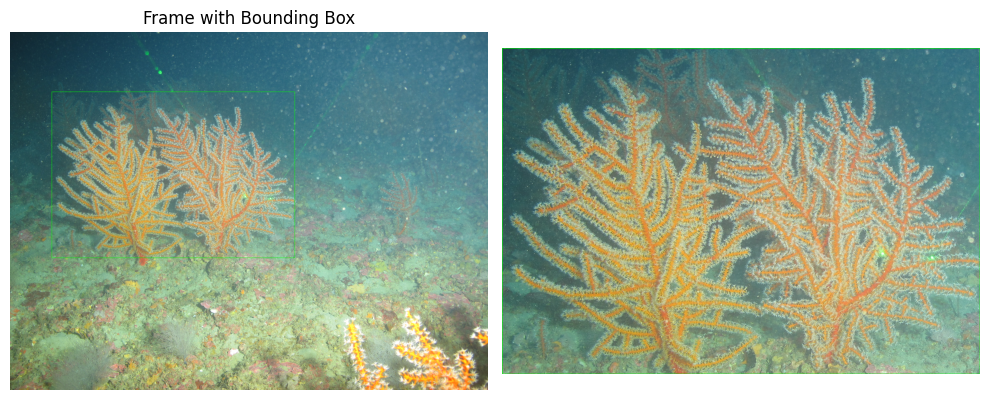

In [29]:
folder_path = './Benthic-Mapping-highlight/benthic_mapping/data/Images/'
media_id = filtered_df['media_id'].iloc[0]
image_path = os.path.join(folder_path, media_id)
frame = cv2.imread(image_path)

# Extract the bounding box
bbox = filtered_df['bbox'].iloc[0]
x_min, y_min, x_max, y_max = bbox

# Draw the bounding box on the frame
cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

# Convert the frame to RGB for displaying with matplotlib
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display the frame with the bounding box
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(frame_rgb)
plt.axis('off')
plt.title(f"Frame with Bounding Box")

# Crop the region corresponding to the bounding box
cropped_region = frame[y_min:y_max, x_min:x_max]
cropped_region_rgb = cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB)

# Display the cropped region
plt.subplot(1, 2, 2)
plt.imshow(cropped_region_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
text_query = "orange coral"

inputs = clip_processor(text=[text_query], return_tensors="pt", padding=True)
with torch.no_grad():
    text_features = clip_model.get_text_features(**inputs)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)  # normalize

In [17]:
image_matrix = np.stack(embedding_df["embedding_vec"].values)
text_vector = text_features.cpu().numpy()
print(text_vector.shape)
print(image_matrix.shape)
# Make sure text_vector is (1, 512)
text_vector = text_vector.squeeze()  # from (1, 1, 512) → (512,)
if text_vector.ndim == 1:
    text_vector = text_vector[np.newaxis, :]  # reshape to (1, 512)

# Make sure image_matrix is (N, 512)
if image_matrix.ndim == 3:
    image_matrix = image_matrix.squeeze()  # from (N, 1, 512) → (N, 512)
# Compute similarity
similarities = cosine_similarity(text_vector, image_matrix)[0]
embedding_df["text_similarity"] = similarities

(1, 768)
(1330, 1, 768)


In [18]:
top_k = 5
top_results = embedding_df.sort_values("text_similarity", ascending=False).head(top_k)
print(top_results[["media_id", "text_similarity"]])

                                           media_id  text_similarity
948  PS2222_20220601T160209Z_FWD_ROV01_IMG_0131.JPG         0.314312
689  PS2222_20220601T154859Z_FWD_ROV01_IMG_0053.JPG         0.306331
27   PS2222_20220601T153924Z_FWD_ROV01_IMG_0007.JPG         0.305428
113  PS2222_20220601T154209Z_FWD_ROV01_IMG_0013.JPG         0.302806
432  PS2222_20220601T154619Z_FWD_ROV01_IMG_0037.JPG         0.302286


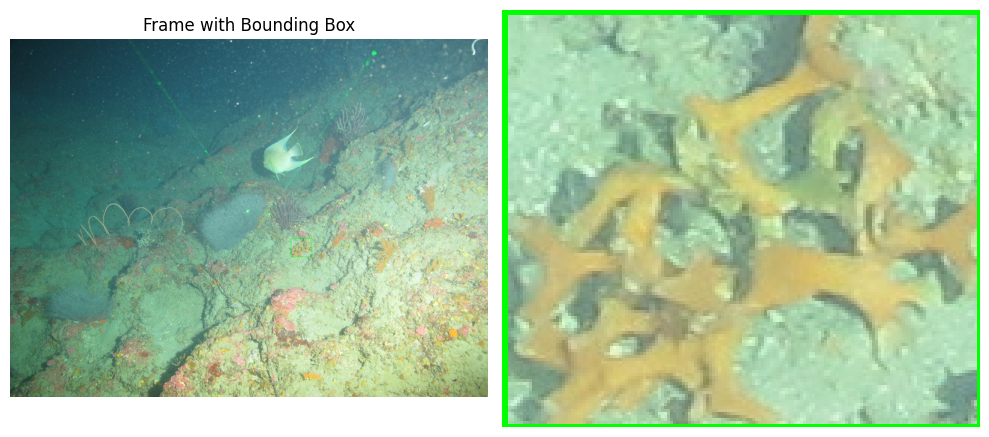

In [19]:
folder_path = './Benthic-Mapping-highlight/benthic_mapping/data/Images/'
media_id = embedding_df['media_id'].iloc[948]
image_path = os.path.join(folder_path, media_id)
frame = cv2.imread(image_path)

# Extract the bounding box
bbox = embedding_df['bbox'].iloc[948]
x_min, y_min, x_max, y_max = bbox

# Draw the bounding box on the frame
cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

# Convert the frame to RGB for displaying with matplotlib
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display the frame with the bounding box
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(frame_rgb)
plt.axis('off')
plt.title(f"Frame with Bounding Box")

# Crop the region corresponding to the bounding box
cropped_region = frame[y_min:y_max, x_min:x_max]
cropped_region_rgb = cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB)

# Display the cropped region
plt.subplot(1, 2, 2)
plt.imshow(cropped_region_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()